## 15.066 Homework 4 Solution Code
Ryan de Freitas Bart & Samuel Newman<br>
August 1 2023

## Load Packages

In [1]:
from HW4_data import *
%whos

Variable   Type       Data/Info
-------------------------------
CE         ndarray    7: 7 elems, type `float64`, 56 bytes
CEU        ndarray    9x7: 63 elems, type `float64`, 504 bytes
OEMD       ndarray    9x7: 63 elems, type `float64`, 504 bytes
PSCU       ndarray    9x7: 63 elems, type `float64`, 504 bytes
SCMT       ndarray    9x7: 63 elems, type `float64`, 504 bytes
UPC        ndarray    9: 9 elems, type `float64`, 72 bytes
np         module     <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>


In [2]:
# Total budget allocated for supply chain
TotalBudget = 3e9; # 3 billion
#TotalBudget = 3.3e9; # 10% increase in budget

# Total TV sets order by the customers from all ODMs by TV size
TotalUnits42 = 920000;
TotalUnits32 = 530000;

# Number of ODMs (treat ODMs making two different sizes as if they were separate ODMs, e.g. count them twice)
NumODM = 9;

# Number of transportation options
NumTran = 7;

# Minimum order size of 42" or 32" TV sets from any selected ODM
MinProd = 200000;

# Maximum order size of 42" or 32" TV sets from any selected ODM
MaxProd = 600000;

# Minimum number of 42" / 32" TV sets shipped by Regular Air or Air Express
MinAir42 = 46000;
MinAir32 = 53000;

# Minimum number of 42" / 32" TV sets shipped by Road, Road LTL, or Road Network
MinRoad42 = 92000;
MinRoad32 = 79500;

# Minimum number of 42" / 32" TV sets shipped by shipped by Rail
MinRail42 = 138000;
MinRail32 = 79500;

In [3]:
import gurobipy as gp
from gurobipy import GRB

# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

<gurobipy.Env, Parameter changes: OutputFlag=0>

In [4]:
# Initialize the model
m = gp.Model(env=env)

### Decision Variables ###

# A vector of binary decision variables that denote which ODMs are selected
X = m.addMVar(NumODM, vtype=GRB.BINARY, name='X')

# Supply Chain Matrix
# Indicates how many TV sets will be produced by the selected ODMs and how they will be shipped to the distribution center
SCM = m.addMVar((NumODM,NumTran), name='SCM')

In [5]:
### Constraints ###
# Total production for each ODM must be greater than the minimum order size if the ODM is selected
Const1a = m.addConstrs((SCM[i,:].sum() >= (MinProd * X[i]) for i in range(NumODM)), name='Const1a')

# Total production for each ODM must be less than the maximum order size if the ODM is selected
Const1b = m.addConstrs((SCM[i,:].sum() <= (MaxProd * X[i]) for i in range(NumODM)), name='Const1b')

In [6]:
# Total number of TVs for each shipping mode must be greater than the Minimum Shipping Requirement
Const2a1 = m.addConstr((SCM[0:7,0:2].sum() >= MinAir42), name='Const2a1') # 42" Air or Air Express
Const2b1 = m.addConstr((SCM[0:7,2:5].sum() >= MinRoad42), name='Const2b1') # 42" Road, Road LTL, or Road Network
Const2c1 = m.addConstr((SCM[0:7,5].sum() >= MinRail42), name='Const2c1') # 42" Rail
Const2a2 = m.addConstr((SCM[7:9,0:2].sum() >= MinAir32), name='Const2a2') # 32" Air or Air Express
Const2b2 = m.addConstr((SCM[7:9,2:5].sum() >= MinRoad32), name='Const2b2') # 32" Road, Road LTL, or Road Network
Const2c2 = m.addConstr((SCM[7:9,5].sum() >= MinRail32), name='Const2c2') # 32" Rail

In [7]:
# ODM5 can't ship by Regular Air, Air Express, Rail, or Water (Hint: SCM [4, 1] corresponding to ODM5 shipping via Air Express)
Const3a = m.addConstr((SCM[4,0] == 0), name='Const3a') # Regular Air
Const3b = m.addConstr((SCM[4,1] == 0), name='Const3b') # Air Express
Const3c = m.addConstr((SCM[4,5] == 0), name='Const3c') # Rail
Const3d = m.addConstr((SCM[4,6] == 0), name='Const3d') # Water

# ODM6 can't ship by Road, Road LTL, Road Network, and Rail
Const4a = m.addConstr((SCM[5,2] == 0), name='Const4a') # Road
Const4b = m.addConstr((SCM[5,3] == 0), name='Const4b') # Road LTL
Const4c = m.addConstr((SCM[5,4] == 0), name='Const4c') # Road Network
Const4d = m.addConstr((SCM[5,5] == 0), name='Const4d') # Rail

In [8]:
# Total cost must be less than total budget
Const5 = m.addConstr((sum(PSCU[i] @ SCM[i] for i in range(NumODM)) <= TotalBudget), name='Const5')

In [9]:
# Total units for each model must be equal to the desired quantities
Const6a = m.addConstr((SCM[0:7,:].sum() == TotalUnits42), name='Const6a') # 42" Total Units
Const6b = m.addConstr((SCM[7:9,:].sum() == TotalUnits32), name='Const6b') # 32" Total Units

In [10]:
# Objective function: minimize CO2 emissions
m.setObjective(sum(CEU[i] @ SCM[i] for i in range(NumODM)), GRB.MINIMIZE)

In [11]:
# Update and write the model
m.update() # Update model parameters
m.write("HW4.lp") # Write model to file

In [12]:
# Solve
m.optimize()

In [13]:
# Print optimal objective function value
print("\nObjective value: ", m.getAttr("ObjVal"))


Objective value:  7401309.890259991


In [14]:
# Print the optimal decsion variable solutions
import pandas as pd
transport_names = ['Air', 'Express', 'Road', 'Road LTL', 'Road-Network', 'Rail', 'Water']
ODM_names = ['LCD 42" ODM1', 'LCD 42" ODM2', 'LCD 42" ODM3', 'LCD 42" ODM4', 'LCD 42" ODM5', 
             'LCD 42" ODM6', 'LCD 42" ODM7', 'LCD 32" ODM1', 'LCD 32" ODM2']

pd.DataFrame(SCM.getAttr('x'), index=ODM_names, columns=transport_names)

,Air,Express,Road,Road LTL,Road-Network,Rail,Water
"LCD 42"" ODM1",0.0,0.0,0.0,0.0,90450.0,0.0,229550.0
"LCD 42"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM3",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM4",46000.0,0.0,0.0,0.0,1550.0,138000.0,414450.0
"LCD 42"" ODM5",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM6",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM7",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 32"" ODM1",53000.0,0.0,0.0,0.0,79500.0,79500.0,318000.0
"LCD 32"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Calculate used budget
np.nan_to_num(np.multiply(PSCU, SCM.getAttr('x'))).sum()

3000000000.0

In [16]:
# Place optimization formulation inside a function to allow different inputs to be run quickly
def ITM_Optimizer(budget_mult):
    # Initialize the model
    m = gp.Model(env=env)

    ### Decision Variables ###

    # A vector of binary decision variables that denote which ODMs are selected
    X = m.addMVar(NumODM, vtype=GRB.BINARY, name='X')

    # Supply Chain Matrix
    # Indicates how many TV sets will be produced by the selected ODMs and how they will be shipped to the distribution center
    SCM = m.addMVar((NumODM,NumTran), name='SCM')

    ### Constraints ###
    # Total production for each ODM must be greater than the minimum order size if the ODM is selected
    Const1a = m.addConstrs((SCM[i,:].sum() >= (MinProd * X[i]) for i in range(NumODM)), name='Const1a')

    # Total production for each ODM must be less than the maximum order size if the ODM is selected
    Const1b = m.addConstrs((SCM[i,:].sum() <= (MaxProd * X[i]) for i in range(NumODM)), name='Const1b')

    # Total number of TVs for each shipping mode must be greater than the Minimum Shipping Requirement
    Const2a1 = m.addConstr((SCM[0:7,0:2].sum() >= MinAir42), name='Const2a1') # 42" Air or Air Express
    Const2b1 = m.addConstr((SCM[0:7,2:5].sum() >= MinRoad42), name='Const2b1') # 42" Road, Road LTL, or Road Network
    Const2c1 = m.addConstr((SCM[0:7,5].sum() >= MinRail42), name='Const2c1') # 42" Rail
    Const2a2 = m.addConstr((SCM[7:9,0:2].sum() >= MinAir32), name='Const2a2') # 32" Air or Air Express
    Const2b2 = m.addConstr((SCM[7:9,2:5].sum() >= MinRoad32), name='Const2b2') # 32" Road, Road LTL, or Road Network
    Const2c2 = m.addConstr((SCM[7:9,5].sum() >= MinRail32), name='Const2c2') # 32" Rail

    # ODM5 can't ship by Regular Air, Air Express, Rail, or Water (Hint: SCM [4, 1] corresponding to ODM5 shipping via Air Express)
    Const3a = m.addConstr((SCM[4,0] == 0), name='Const3a') # Regular Air
    Const3b = m.addConstr((SCM[4,1] == 0), name='Const3b') # Air Express
    Const3c = m.addConstr((SCM[4,5] == 0), name='Const3c') # Rail
    Const3d = m.addConstr((SCM[4,6] == 0), name='Const3d') # Water

    # ODM6 can't ship by Road, Road LTL, Road Network, and Rail
    Const4a = m.addConstr((SCM[5,2] == 0), name='Const4a') # Road
    Const4b = m.addConstr((SCM[5,3] == 0), name='Const4b') # Road LTL
    Const4c = m.addConstr((SCM[5,4] == 0), name='Const4c') # Road Network
    Const4d = m.addConstr((SCM[5,5] == 0), name='Const4d') # Rail

    # Total cost must be less than total budget
    Const5 = m.addConstr((sum(PSCU[i] @ SCM[i] for i in range(NumODM)) <= TotalBudget*(1+budget_mult)), name='Const5')

    # Total units for each model must be equal to the desired quantities
    Const6a = m.addConstr((SCM[0:7,:].sum() == TotalUnits42), name='Const6a') # 42" Total Units
    Const6b = m.addConstr((SCM[7:9,:].sum() == TotalUnits32), name='Const6b') # 32" Total Units

    # Objective function: minimize CO2 emissions
    m.setObjective(sum(CEU[i] @ SCM[i] for i in range(NumODM)), GRB.MINIMIZE)

    m.update() # Update model parameters
    # Solve
    m.optimize()
    
    print("\nObjective value: ", m.getAttr("ObjVal"))

    return m.getAttr("ObjVal")

In [17]:
# Run optimization for a range of increased budgets
budget_mults = np.arange(0, .16, .02)
obj_vals = []
for i in range (0,budget_mults.size):
    obj_vals.append(ITM_Optimizer(budget_mults[i]))


Objective value:  7401309.890259991

Objective value:  5513060.483081695

Objective value:  4542391.076797708

Objective value:  3572591.489201123

Objective value:  3502042.7601499995

Objective value:  3479982.2601499995

Objective value:  3416981.696213361

Objective value:  3373499.9820685117


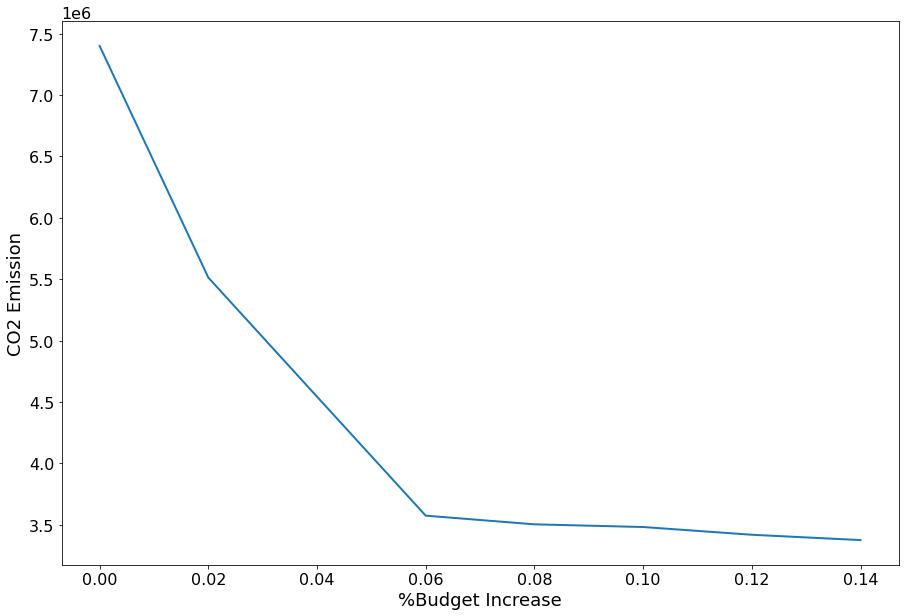

In [18]:
# Graph results
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': [15, 10],
    'font.size': 20,
    'axes.titlesize' : 20,
    'axes.labelsize' : 18,
    'lines.linewidth' : 2,
    'lines.markersize' : 10,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16
})

plt.plot(budget_mults, obj_vals)
plt.xlabel("%Budget Increase")
plt.ylabel("CO2 Emission");
plt.savefig('Budget_vs_CO2.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()